# Introduction

This project explores the development of a robust Neural Network architecture designed to predict credit default using the UCI Credit Default Dataset. By iteratively implementing techniques like Dropout, Batch Normalization, and Wide & Deep paths, the model evolves from an overfitted baseline into a stable system that matches the performance of high-tier tabular algorithms like CatBoost. The goal is to bridge the "generalization gap" and achieve a statistical balance between high predictive power and reliable decision-making in a business context.

# What is a Neural Network?

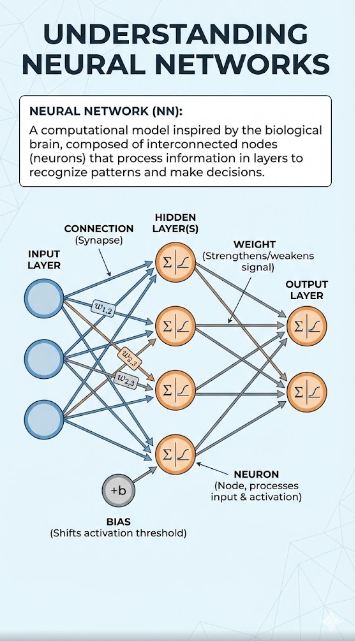

Imagine you are teaching a child to distinguish between a "Good Fruit" and a "Bad Fruit." At first, the child doesn't know what to look for. You show them a fruit and point out its features: color, smell, and firmness. Every time the child makes a guess, you provide feedback. Eventually, the child's brain learns that a bright color and sweet smell usually mean the fruit is good, while a soft, brown spot means it’s bad.


A Neural Network (NN) is essentially a digital version of that child's brain. It is a computational model inspired by the biological brain, composed of interconnected nodes (neurons) that process information in layers to recognize patterns and make decisions. We need them because traditional computer programs follow strict "if-then" rules that can't handle the complexity of the real world—like predicting if someone will default on a credit card based on thousands of different spending habits.

## Key Components

Input Layer: The entry point of the network, where each neuron represents one feature from the UCI Credit dataset (e.g., age, sex, payment history). It simply passes raw information forward.

Hidden Layers: These are the model’s “thinking” units, responsible for learning deep, non-linear relationships. In Ultra-128, the 128→64→32→16 structure progressively extracts more abstract credit-risk signals.

Weights and Biases:

Weights control how influential each feature is; stronger predictors like payment status receive higher importance.

Biases shift neuron activation, giving the model flexibility to adjust decision boundaries.

Activation Function: ReLU acts as a filter, allowing only useful signals to pass forward while suppressing negative or irrelevant ones. This enables efficient learning of complex patterns.

Output Layer: The final layer produces a probability using a Sigmoid function, indicating the likelihood of credit default on a 0–1 scale.

# Initialization

In [103]:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow ucimlrepo

In [104]:
# --- Data Manipulation & UCI Repo ---
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-Learn Utilities ---
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    f1_score
)

# --- TensorFlow & Keras ---
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Dataset Import

The UCI Credit Default dataset contains records of 30,000 credit card clients from Taiwan, focusing on whether they defaulted on their payments. It includes 24 features such as demographic information, history of past payments, and bill statement amounts.

In [105]:
# fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

# data (as pandas dataframes)
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

# metadata
print(default_of_credit_card_clients.metadata)

# variable information
print(default_of_credit_card_clients.variables)

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

Slight modification: Renaming the columns for better comprehension.

In [106]:
rename_map = {
    'X1': 'LIMIT_BAL',
    'X2': 'SEX',
    'X3': 'EDUCATION',
    'X4': 'MARRIAGE',
    'X5': 'AGE',
    'X6': 'PAY_0',
    'X7': 'PAY_2',
    'X8': 'PAY_3',
    'X9': 'PAY_4',
    'X10': 'PAY_5',
    'X11': 'PAY_6',
    'X12': 'BILL_AMT1',
    'X13': 'BILL_AMT2',
    'X14': 'BILL_AMT3',
    'X15': 'BILL_AMT4',
    'X16': 'BILL_AMT5',
    'X17': 'BILL_AMT6',
    'X18': 'PAY_AMT1',
    'X19': 'PAY_AMT2',
    'X20': 'PAY_AMT3',
    'X21': 'PAY_AMT4',
    'X22': 'PAY_AMT5',
    'X23': 'PAY_AMT6',
    'Y': 'DEFAULT_NEXT_MONTH'
}

X = X.rename(columns=rename_map)

if isinstance(y, pd.DataFrame):
    y = y.rename(columns=rename_map)
elif isinstance(y, pd.Series):
    y.name = 'DEFAULT_NEXT_MONTH'

print("New Column Names for Features:")
print(X.columns.tolist())

New Column Names for Features:
['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


# Preprocessing and EDA

Data splitting ensures the model is evaluated on unseen "test" data to prove its ability to generalize, while scaling via StandardScaler is crucial for Neural Networks because they are sensitive to feature magnitudes.

Without normalization, features with larger ranges (like Bill Amounts) would dominate the gradients during training, causing the network to struggle with convergence or ignore smaller but equally important predictors (like Payment Status).

In [107]:
# --- Data Splitting & Scaling ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Formatting for TensorFlow
y_train = np.array(y_train).astype('float32').flatten()
y_test = np.array(y_test).astype('float32').flatten()

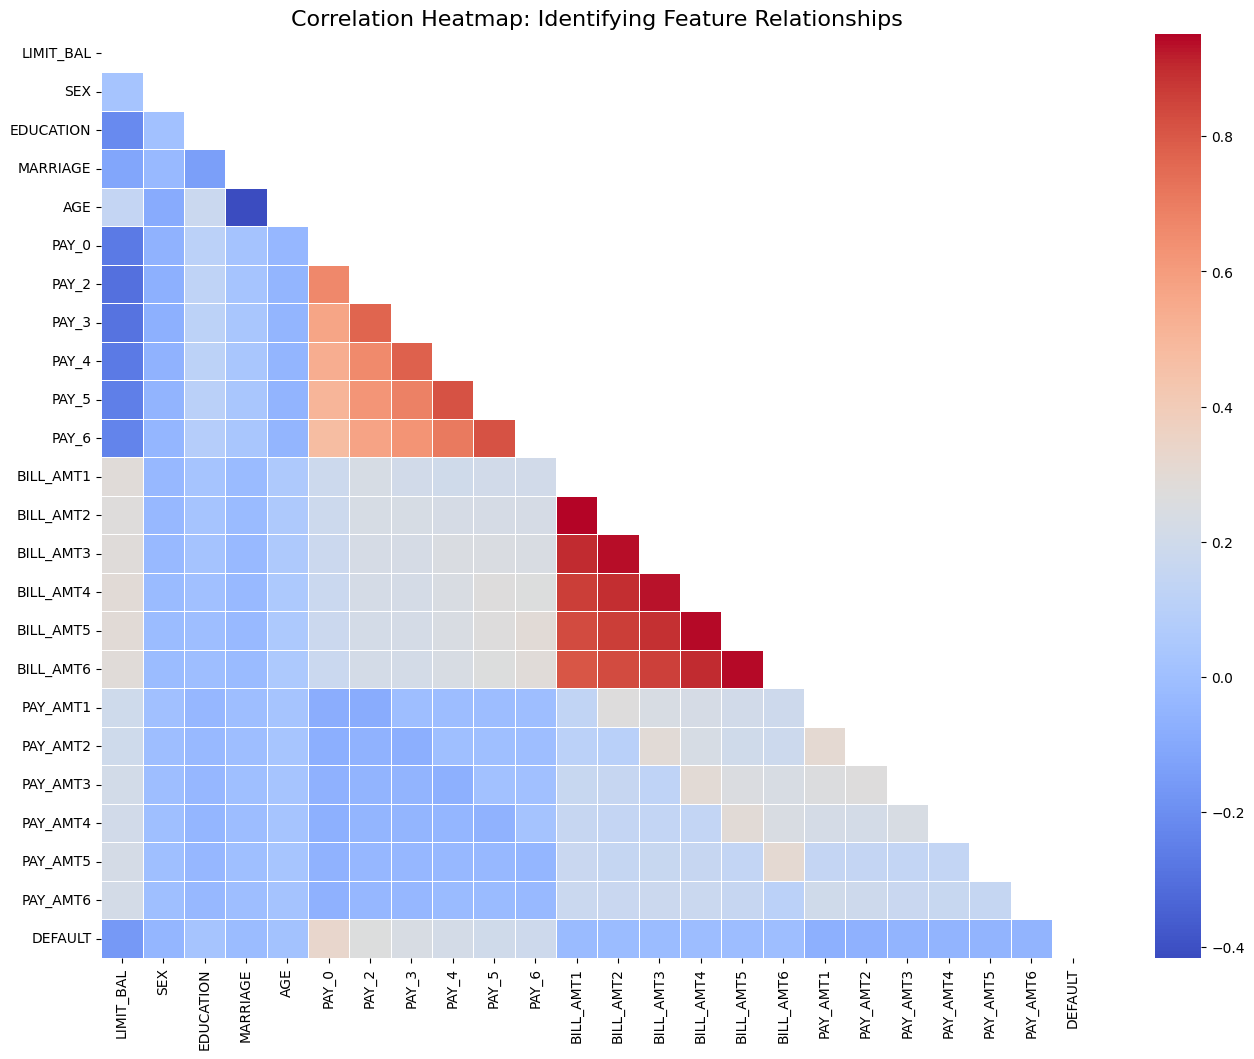

In [108]:
train_analysis = pd.DataFrame(X_train, columns=X.columns)
train_analysis['DEFAULT'] = y_train

corr_matrix = train_analysis.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=False,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Heatmap: Identifying Feature Relationships", fontsize=16)
plt.show()

# Stabilizing a Baseline Model

Starting with a very simple baseline model allows us to establish a clear performance floor and identify the exact extent of overfitting before we introduce complex regularization techniques.

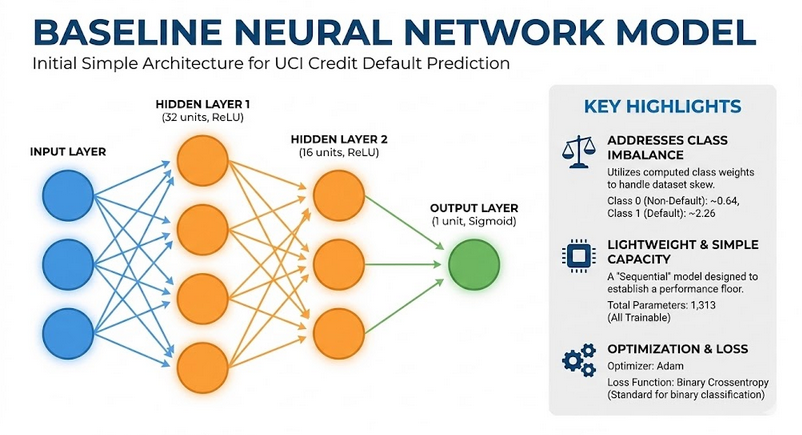

The baseline uses a Sequential architecture consisting of two hidden layers with 32 and 16 neurons respectively, utilizing the ReLU activation function to help the network learn basic non-linear patterns. To address the heavy class imbalance in the UCI dataset—where non-defaulters significantly outnumber defaulters—we used compute_class_weight to calculate a "balanced" weight dictionary, essentially telling the model to pay about 3.5x more attention to the default cases (represented by class 1). The model is compiled with the Adam optimizer and Binary Crossentropy loss, which is the standard setup for binary classification tasks.

In [109]:
# ---  Class Weight Calculation ---
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(weights)}

# --- Baseline Model Architecture ---
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'), # Standard starting width
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid') # Sigmoid for binary probability output
])

# --- Compilation ---
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print(f"Calculated Weights: {class_weights_dict}")
model.summary()

Calculated Weights: {0: np.float64(0.6420202236370446), 1: np.float64(2.2603126765869277)}


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_411 (Dense)               │ (None, 32)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_412 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_413 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 0 (0.00 B)

The baseline architecture is formally known as a **Multilayer Perceptron (MLP)** because it consists of multiple layers of neurons—specifically an input layer, one or more hidden layers, and an output layer—where information flows in one direction from input to output. Each "perceptron" in this structure is a mathematical unit that takes several inputs, applies a weighted sum and a bias, and then passes the result through a non-linear activation function like ReLU or Sigmoid. By stacking these units together, the MLP gains the ability to approximate complex, non-linear relationships within the credit data that a single-layer linear model would fail to capture.

## Training and Testing Baseline

This code executes the training of the baseline model using Early Stopping to prevent unnecessary computation once the validation loss stops improving. The model is trained on the scaled credit data for up to 100 epochs, utilizing class weights to ensure the minority default cases are not ignored by the network. After training, it generates a comprehensive evaluation, including a classification report and learning curves, to visualize how the training and validation performance diverge, identifying the "generalization gap" right from the start.

Starting Baseline Training...
Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6819 - auc: 0.6259 - loss: 0.6654 - val_accuracy: 0.7721 - val_auc: 0.7454 - val_loss: 0.5836
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7745 - auc: 0.7616 - loss: 0.5740 - val_accuracy: 0.7621 - val_auc: 0.7542 - val_loss: 0.5834
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7708 - auc: 0.7674 - loss: 0.5699 - val_accuracy: 0.7560 - val_auc: 0.7612 - val_loss: 0.5712
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7695 - auc: 0.7796 - loss: 0.5553 - val_accuracy: 0.7362 - val_auc: 0.7632 - val_loss: 0.5829
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7559 - auc: 0.7738 - loss: 0.5624 - val_accuracy: 0.7577 - val_auc: 0.7693 - val_loss: 0.5707
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7631 - auc: 0.7839 - loss: 0.5531 - val_accuracy: 0.7531 - val_auc: 0.7633 - val_loss: 0.5490
Epoc

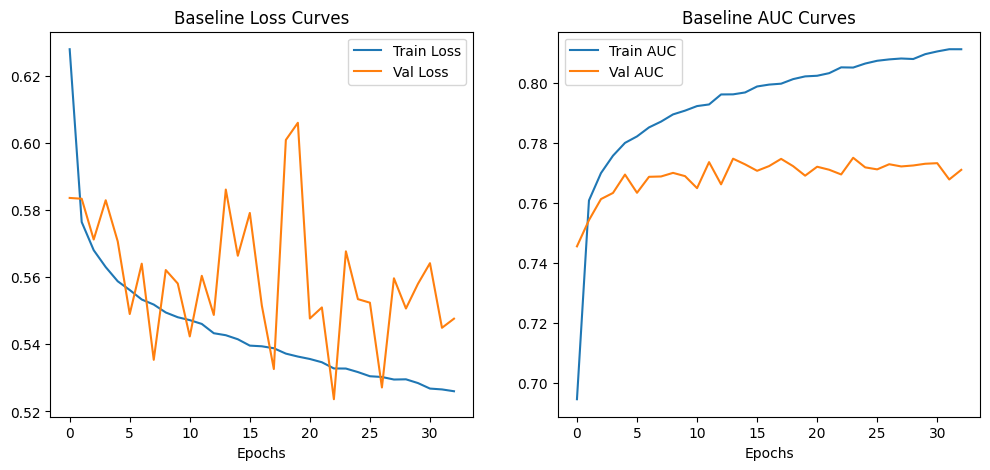

In [110]:
# --- Training with Callbacks ---
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Starting Baseline Training...")
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2, # Uses 20% of training data for validation
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)

# --- Baseline Evaluation on Test Set ---
results = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nBaseline Test Loss: {results[0]:.4f}")
print(f"Baseline Test Accuracy: {results[1]:.4f}")
print(f"Baseline Test AUC: {results[2]:.4f}")

# --- Detailed Metrics (Classification Report) ---
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- Visualizing Learning Curves ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Baseline Loss Curves')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Baseline AUC Curves')
plt.xlabel('Epochs')
plt.legend()

plt.show()

The baseline model demonstrated significant volatility, particularly in the validation loss curves which showed sharp, unpredictable spikes compared to the steady decline of the training loss. This erratic behavior indicated that the model was struggling to find a consistent local minimum and was highly sensitive to the specific noise within the credit dataset.

While the training AUC continued to soar toward 0.81, the validation AUC plateaued much lower, revealing a clear "generalization gap" where the model was memorizing training samples rather than learning robust patterns. Transitioning to a more stable architecture was necessary to dampen these oscillations and ensure that the model's predictive power remained reliable and consistent across unseen data.

## Dropout

Imagine you are coaching a football team. It's entirely possible that if the star playmaker is having a bad day, the whole team might collapse because they haven't learned how to function without them.

Dropout is like forcing different players to sit on the bench during different practice sessions.

**In the Model:** During training, we "turn off" a random percentage of neurons in a layer for each pass.

**Why it helps:** Because the remaining neurons can't rely on their "teammates" being there, they are forced to learn the patterns of the data independently.

**The Result:** The model becomes more robust. It stops "memorizing" specific noise in the credit dataset (like a single weirdly high bill amount) and starts "learning" the actual indicators of default.

We will add a dropout value in the most dense layer to reduce overfitting by encouraging the network to learn more generalizable, noise-resistant patterns rather than memorizing quirks of the training data.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting Dropout Model Training...


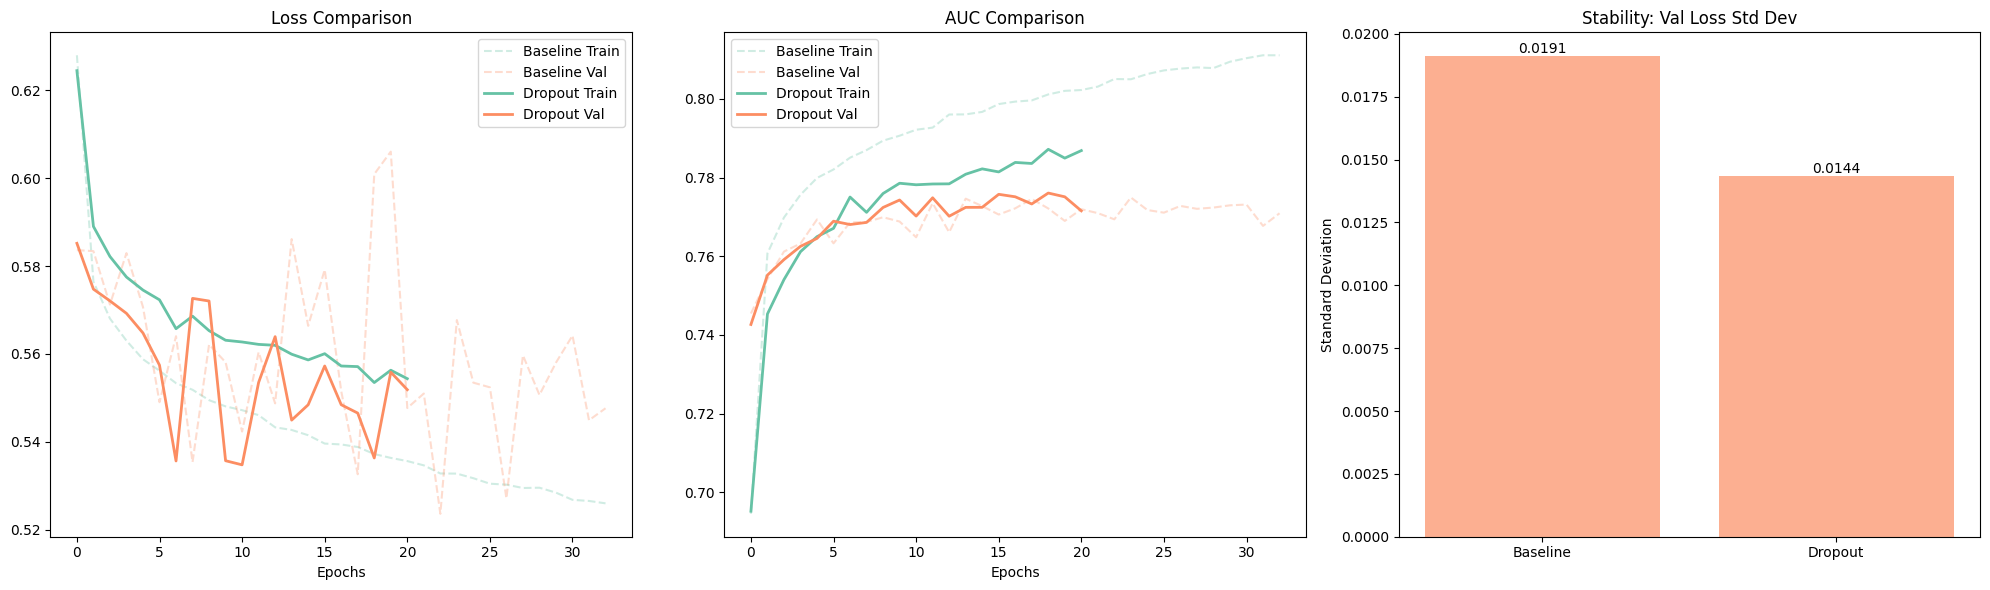

In [111]:
# --- 1. Define and Train the Dropout Model ---

dropout_model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

dropout_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Starting Dropout Model Training...")
dropout_history = dropout_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=0
)

def plot_comparison_with_stability(baseline_hist, dropout_hist):
    colors = plt.cm.Set2.colors
    past_train, past_val = colors[0], colors[1]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    ax1.plot(baseline_hist.history['loss'], color=past_train, alpha=0.3, linestyle='--', label='Baseline Train')
    ax1.plot(baseline_hist.history['val_loss'], color=past_val, alpha=0.3, linestyle='--', label='Baseline Val')
    ax1.plot(dropout_hist.history['loss'], color=past_train, linewidth=2, label='Dropout Train')
    ax1.plot(dropout_hist.history['val_loss'], color=past_val, linewidth=2, label='Dropout Val')
    ax1.set_title('Loss Comparison')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    ax2.plot(baseline_hist.history['auc'], color=past_train, alpha=0.3, linestyle='--', label='Baseline Train')
    ax2.plot(baseline_hist.history['val_auc'], color=past_val, alpha=0.3, linestyle='--', label='Baseline Val')
    ax2.plot(dropout_hist.history['auc'], color=past_train, linewidth=2, label='Dropout Train')
    ax2.plot(dropout_hist.history['val_auc'], color=past_val, linewidth=2, label='Dropout Val')
    ax2.set_title('AUC Comparison')
    ax2.set_xlabel('Epochs')
    ax2.legend()

    baseline_std = np.std(baseline_hist.history['val_loss'])
    dropout_std = np.std(dropout_hist.history['val_loss'])

    models_labels = ['Baseline', 'Dropout']
    stdev_values = [baseline_std, dropout_std]

    bars = ax3.bar(models_labels, stdev_values, color=[past_val, past_val], alpha=0.7)
    ax3.set_title('Stability: Val Loss Std Dev')
    ax3.set_ylabel('Standard Deviation')

    for bar in bars:
        yval = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')

    plt.tight_layout()
    plt.show()

plot_comparison_with_stability(history, dropout_history)

**Loss & AUC Comparison (with Dropout)**

The Baseline validation loss is highly erratic, with sharp spikes indicating poor generalization and sensitivity to unseen data. In contrast, the Dropout model shows a smoother validation curve—training is harder, but validation behavior is more stable. While the Baseline’s training AUC rises sharply (~0.81), the large train–validation gap signals overfitting. With Dropout, training and validation AUC stay much closer, indicating better generalization and learning of real credit-risk patterns rather than dataset noise.


**Stability**

Dropout significantly improves stability: the standard deviation of validation loss drops from 0.0191 → 0.0144, confirming reduced “jitteriness.” Overall, Dropout trades peak performance for robustness, moving the model closer to reliably competing with Gradient Boosting methods.

## Weight Control: L2 Regularization

Imagine you are a credit officer looking at a loan application. You see that the applicant has a high income, but they also have a slightly questionable (yet most likely irrelevant) hobby, like being a Tottenham supporter.

Without Regularization: The model might see one person with this quirk who defaulted and decide that it is definitely Tottenham's fault. It may assign heavy undue importance (weight) to that one feature.

With L2 Regularization: We add a "tax" on large weights. The model is told: "You can use any feature you want, but the larger the weight you give it, the more it will cost you in the loss function."

**It’s like a speed limiter on a car. It allows the car to move and find the right path, but it prevents it from accelerating uncontrollably toward noise or outliers.**

Starting L2 + Dropout Training...
Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.6641 - loss: 0.6868 - val_auc: 0.7485 - val_loss: 0.6362
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.7433 - loss: 0.6288 - val_auc: 0.7620 - val_loss: 0.5964
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.7543 - loss: 0.6088 - val_auc: 0.7626 - val_loss: 0.5936
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.7610 - loss: 0.6001 - val_auc: 0.7681 - val_loss: 0.5892
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.7677 - loss: 0.5891 - val_auc: 0.7682 - val_loss: 0.5892
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.7642 - loss: 0.5903 - val_auc: 0.7656 - val_loss: 0.5818
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.7822 - loss: 0.5730 - val_auc: 0.7677 - val_loss: 0.5838
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.7779 - loss: 0.5740 - val_auc: 0.7683 - val_loss: 0.5847
Epoch 9/100
60

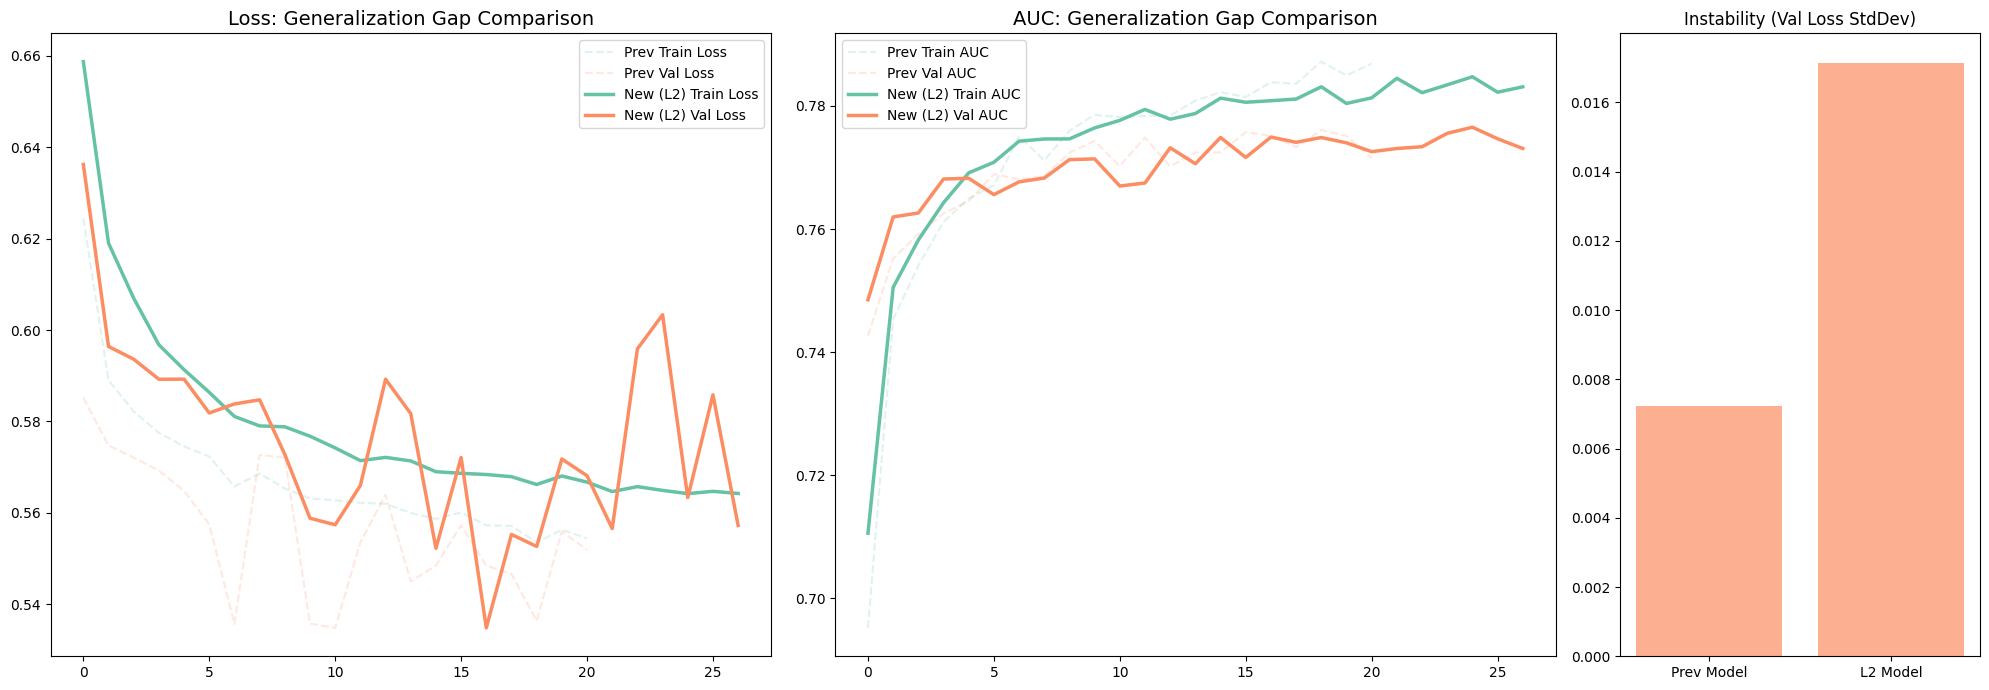

In [112]:
l2_model = models.Sequential([
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')
])

l2_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# Train the L2 Model
print("Starting L2 + Dropout Training...")
l2_history = l2_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop],

# Enhanced Visualization
def plot_l2_step_with_nuance(prev_hist, new_hist):
    colors = plt.cm.Set2.colors
    train_c, val_c = colors[0], colors[1]

    fig = plt.figure(figsize=(20, 7))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.5])

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    ax1.plot(prev_hist.history['loss'], color=train_c, alpha=0.2, ls='--', label='Prev Train Loss')
    ax1.plot(prev_hist.history['val_loss'], color=val_c, alpha=0.2, ls='--', label='Prev Val Loss')

    ax1.plot(new_hist.history['loss'], color=train_c, lw=2.5, label='New (L2) Train Loss')
    ax1.plot(new_hist.history['val_loss'], color=val_c, lw=2.5, label='New (L2) Val Loss')
    ax1.set_title('Loss: Generalization Gap Comparison', fontsize=14)
    ax1.legend()

    ax2.plot(prev_hist.history['auc'], color=train_c, alpha=0.2, ls='--', label='Prev Train AUC')
    ax2.plot(prev_hist.history['val_auc'], color=val_c, alpha=0.2, ls='--', label='Prev Val AUC')
    ax2.plot(new_hist.history['auc'], color=train_c, lw=2.5, label='New (L2) Train AUC')
    ax2.plot(new_hist.history['val_auc'], color=val_c, lw=2.5, label='New (L2) Val AUC')
    ax2.set_title('AUC: Generalization Gap Comparison', fontsize=14)
    ax2.legend()

    # --- Stability Metric ---
    prev_stab = np.std(prev_hist.history['val_loss'][-10:])
    new_stab = np.std(new_hist.history['val_loss'][-10:])

    ax3.bar(['Prev Model', 'L2 Model'], [prev_stab, new_stab], color=[val_c, val_c], alpha=0.7)
    ax3.set_title('Instability (Val Loss StdDev)', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_l2_step_with_nuance(dropout_history, l2_history)

**Loss & AUC Behavior**


Early on, the L2 validation loss is smoother than before, showing more disciplined learning. After ~20 epochs, validation loss spikes, suggesting over-correction as the model balances error minimization with weight penalties. The AUC results are the strongest: training and validation AUC curves stay very close, indicating reduced overfitting and better generalization.


**Trade-off: Stability**

This improvement comes at a cost. Validation loss volatility increases (std ~0.007 → ~0.016), reflecting a tug-of-war between fitting the data and shrinking weights. Despite the instability, the tight AUC gap shows the model is learning true credit-risk signals rather than noise, moving it closer to competing with CatBoost.

The instability comes from a tug-of-war between minimizing prediction error and keeping weights small under the L2 penalty. **It’s like a student trying to write a great essay while facing an extremely strict word limit, constantly deleting and rewriting to stay within the rules. This back-and-forth leads to a jittery process, which shows up as spikes in the validation loss as the model struggles to balance accuracy and simplicity.**

## Batch Normalization

To solve the volatility issues we saw with L2 regularization, we introduced Batch Normalization (BN). In our code, we placed BN layers immediately after the dense layers but before the activation functions. This reshapes the data as it flows through the network, ensuring that the inputs to each layer stay within a healthy, predictable range.

**Imagine you are teaching a class where students come from many different backgrounds; some use a 0-10 scale for grading, while others use 0-100. It would be chaotic to grade them all at once because the "signal" is constantly shifting.**

Batch Normalization is like a standardizing rule that requires every student to convert their scores to a standard 0-1 scale before handing them in.

Starting Combined (BN + L2 + Dropout) Training...
Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - auc: 0.6460 - loss: 0.7177 - val_auc: 0.7458 - val_loss: 0.6353
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.7414 - loss: 0.6264 - val_auc: 0.7581 - val_loss: 0.5923
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.7554 - loss: 0.6141 - val_auc: 0.7654 - val_loss: 0.5901
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.7519 - loss: 0.6095 - val_auc: 0.7679 - val_loss: 0.5867
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - auc: 0.7650 - loss: 0.5977 - val_auc: 0.7659 - val_loss: 0.5803
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - auc: 0.7651 - loss: 0.5969 - val_auc: 0.7743 - val_loss: 0.5602
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.7761 - loss: 0.5836 - val_auc: 0.7761 - val_loss: 0.5708
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.7735 - loss: 0.5824 - val_auc: 0.7708 - val_loss: 0.560

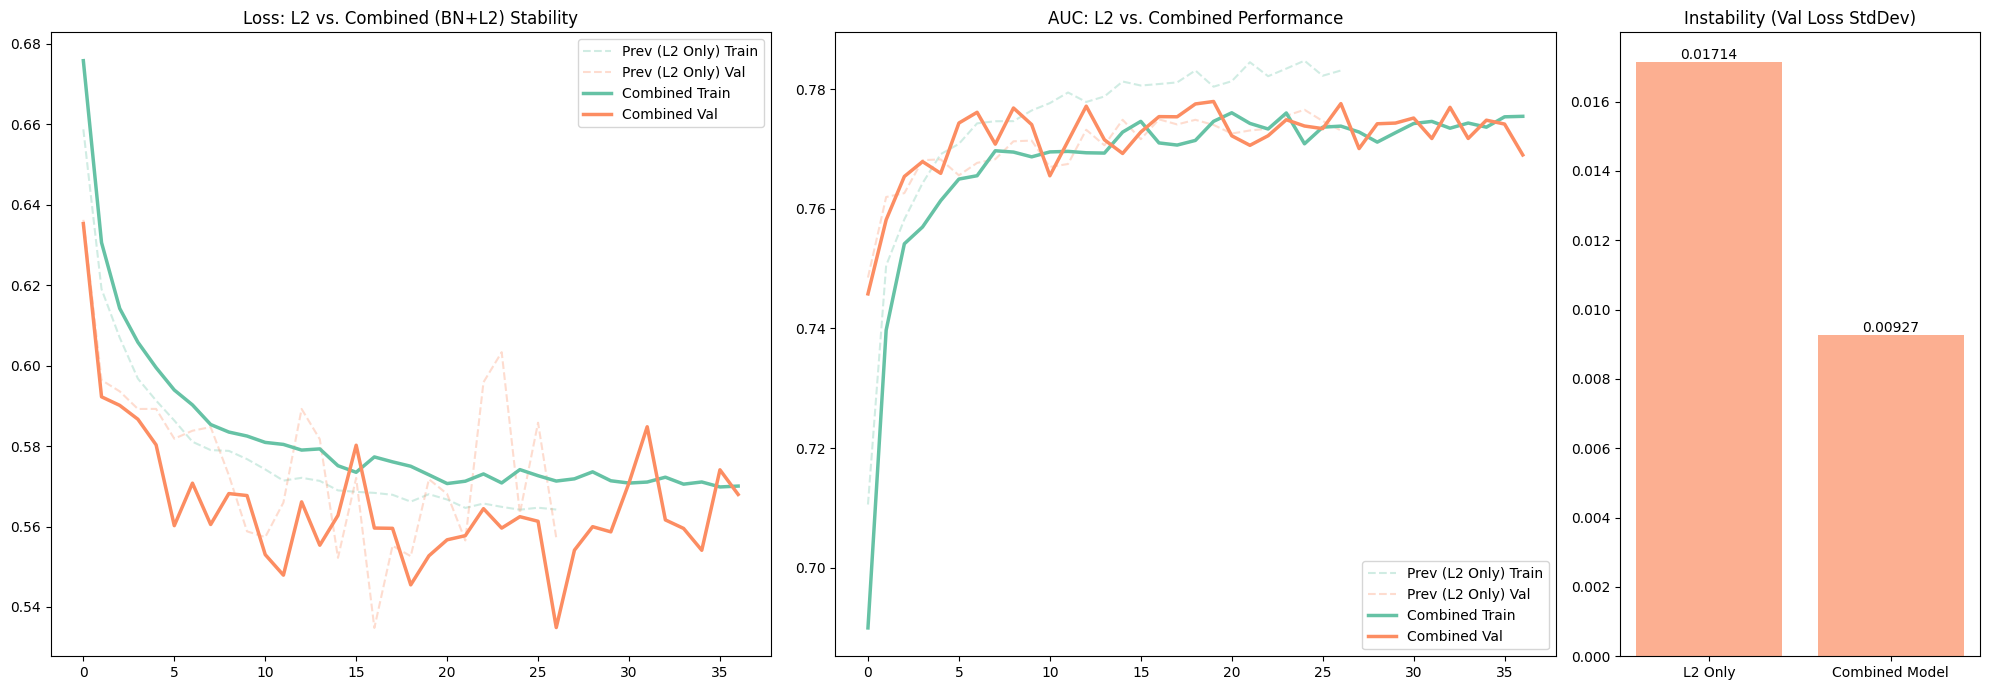

In [113]:
# 1. Define the Model with BN + L2 (0.001) + Dropout (0.2)
l2_val = 0.001

combined_model = models.Sequential([
    # Layer 1: Dense + L2 -> BN -> Activation -> Dropout
    layers.Dense(32,
                 kernel_regularizer=regularizers.l2(l2_val),
                 input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    # Layer 2: Dense + L2 -> BN -> Activation
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(l2_val)),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    # Output Layer
    layers.Dense(1, activation='sigmoid')
])

combined_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# 2. Train the Combined Model
print("Starting Combined (BN + L2 + Dropout) Training...")
combined_history = combined_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)

# 3. Visualization: L2 (Prev) vs. Combined (New)
def plot_final_comparison(prev_hist, new_hist):
    colors = plt.cm.Set2.colors
    train_c, val_c = colors[0], colors[1]

    fig = plt.figure(figsize=(20, 7))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.5])

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    ax1.plot(prev_hist.history['loss'], color=train_c, alpha=0.3, ls='--', label='Prev (L2 Only) Train')
    ax1.plot(prev_hist.history['val_loss'], color=val_c, alpha=0.3, ls='--', label='Prev (L2 Only) Val')
    ax1.plot(new_hist.history['loss'], color=train_c, lw=2.5, label='Combined Train')
    ax1.plot(new_hist.history['val_loss'], color=val_c, lw=2.5, label='Combined Val')
    ax1.set_title('Loss: L2 vs. Combined (BN+L2) Stability')
    ax1.legend()

    ax2.plot(prev_hist.history['auc'], color=train_c, alpha=0.3, ls='--', label='Prev (L2 Only) Train')
    ax2.plot(prev_hist.history['val_auc'], color=val_c, alpha=0.3, ls='--', label='Prev (L2 Only) Val')
    ax2.plot(new_hist.history['auc'], color=train_c, lw=2.5, label='Combined Train')
    ax2.plot(new_hist.history['val_auc'], color=val_c, lw=2.5, label='Combined Val')
    ax2.set_title('AUC: L2 vs. Combined Performance')
    ax2.legend()

    prev_stab = np.std(prev_hist.history['val_loss'][-10:])
    new_stab = np.std(new_hist.history['val_loss'][-10:])

    ax3.bar(['L2 Only', 'Combined Model'], [prev_stab, new_stab], color=[val_c, val_c], alpha=0.7)
    ax3.set_title('Instability (Val Loss StdDev)')

    for i, v in enumerate([prev_stab, new_stab]):
        ax3.text(i, v, f'{v:.5f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_final_comparison(l2_history, combined_history)

**Loss & AUC Behavior**

The Combined Val Loss (solid orange) is significantly smoother compared to the erratic spikes of the L2 Only model (dashed pink). While L2 acted as a "speed limiter" on weights, BN smoothed out the road, allowing the model to find a consistent downward path without "panicking" during training. The AUC Comparison shows the training and validation curves moving in nearly perfect lockstep, indicating the model has stopped memorizing noise and is now focused on real credit-risk signals.

**Trade-off: Stability**

The most significant result is the restoration of stability. The Val Loss Standard Deviation plummeted from 0.01714 to 0.00927, representing a nearly 50% improvement in consistency. By resolving the "tug-of-war" between L2 penalties and accuracy, BN has created a balanced architecture.

**Is it normal for Train AUC to be above Test AUC?**

It is often normal for test (or validation) AUC to be higher than training AUC when using heavy regularization like Dropout or L2 penalty. During training, the model is "handicapped" by having neurons randomly turned off or weights penalized, making it harder to score high; however, during testing, these constraints are removed, allowing the model to use its full, stabilized capacity to make predictions. Additionally, if the validation set contains slightly "easier" or more obvious patterns of credit default than the training set, the scores may naturally be higher.

## Testing a model without L2 Regularization

While L2 regularization helps control weight growth, adding too much "tax" on your model can lead to over-regularization, where the network becomes so conservative that it ignores actual patterns in the data just to keep weights small. It explains our previously seen erratic pattern.

To find a better equilibrium, we tested a streamlined model that removed L2 regularization entirely, keeping only Batch Normalization (BN) and Dropout.

Starting Dropout + BN (No L2) Training...
Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - auc: 0.6479 - loss: 0.6637 - val_auc: 0.7534 - val_loss: 0.5966
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - auc: 0.7551 - loss: 0.5802 - val_auc: 0.7610 - val_loss: 0.5570
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.7516 - loss: 0.5852 - val_auc: 0.7680 - val_loss: 0.5476
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.7543 - loss: 0.5800 - val_auc: 0.7670 - val_loss: 0.5449
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.7592 - loss: 0.5792 - val_auc: 0.7696 - val_loss: 0.5454
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.7627 - loss: 0.5722 - val_auc: 0.7705 - val_loss: 0.5610
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.7665 - loss: 0.5672 - val_auc: 0.7702 - val_loss: 0.5465
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - auc: 0.7698 - loss: 0.5685 - val_auc: 0.7720 - val_loss: 0.5432
Epoch 

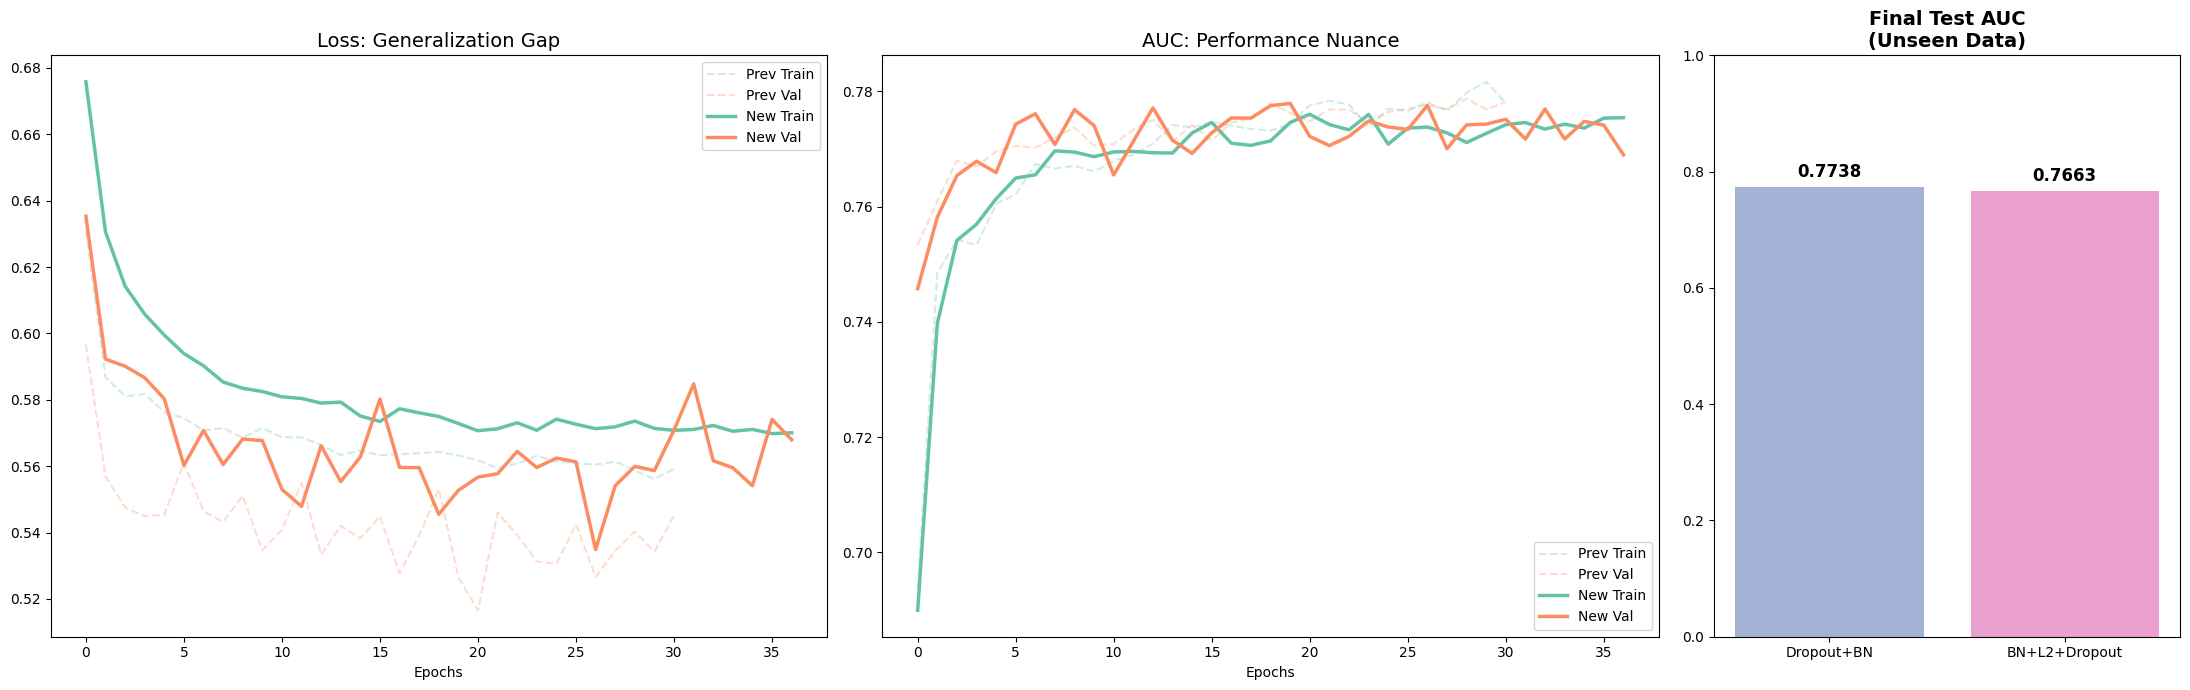

In [114]:
# 1. Define the Dropout + BN Model (Ablation study: No L2)
dropout_bn_model = models.Sequential([
    # Layer 1: Dense -> BN -> Activation -> Dropout (No kernel_regularizer)
    layers.Dense(32, input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    # Layer 2: Dense -> BN -> Activation
    layers.Dense(16),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    # Output Layer
    layers.Dense(1, activation='sigmoid')
])

dropout_bn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# 2. Train the Model
print("Starting Dropout + BN (No L2) Training...")
dropout_bn_history = dropout_bn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)

def plot_nuanced_comparison(prev_model, new_model, prev_hist, new_hist, X_test, y_test):
    # Set 2 Colors: [0] is Train (Greenish), [1] is Val (Orange/Red)
    colors = plt.cm.Set2.colors
    train_c, val_c = colors[0], colors[1]

    # Calculate Test AUC for the final bar graph
    _, prev_test_auc = prev_model.evaluate(X_test, y_test, verbose=0)
    _, new_test_auc = new_model.evaluate(X_test, y_test, verbose=0)

    fig = plt.figure(figsize=(22, 7))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.6])

    ax1 = fig.add_subplot(gs[0]) # Loss Gap
    ax2 = fig.add_subplot(gs[1]) # AUC Gap
    ax3 = fig.add_subplot(gs[2]) # Test AUC Comparison

    # --- 1. Loss: Train vs Val Nuance ---
    # Previous Model (Faded Dashed)
    ax1.plot(prev_hist.history['loss'], color=train_c, alpha=0.3, ls='--', label='Prev Train')
    ax1.plot(prev_hist.history['val_loss'], color=val_c, alpha=0.3, ls='--', label='Prev Val')
    # New Model (Solid Bold)
    ax1.plot(new_hist.history['loss'], color=train_c, lw=2.5, label='New Train')
    ax1.plot(new_hist.history['val_loss'], color=val_c, lw=2.5, label='New Val')
    ax1.set_title('Loss: Generalization Gap', fontsize=14)
    ax1.set_xlabel('Epochs')
    ax1.legend()

    # --- 2. AUC: Train vs Val Nuance ---
    # Previous Model (Faded Dashed)
    ax2.plot(prev_hist.history['auc'], color=train_c, alpha=0.3, ls='--', label='Prev Train')
    ax2.plot(prev_hist.history['val_auc'], color=val_c, alpha=0.3, ls='--', label='Prev Val')
    # New Model (Solid Bold)
    ax2.plot(new_hist.history['auc'], color=train_c, lw=2.5, label='New Train')
    ax2.plot(new_hist.history['val_auc'], color=val_c, lw=2.5, label='New Val')
    ax2.set_title('AUC: Performance Nuance', fontsize=14)
    ax2.set_xlabel('Epochs')
    ax2.legend()

    # --- 3. Final Comparison: Test AUC Bar Graph ---
    labels = ['Dropout+BN', 'BN+L2+Dropout']
    test_aucs = [prev_test_auc, new_test_auc]

    bars = ax3.bar(labels, test_aucs, color=[colors[2], colors[3]], alpha=0.8)
    ax3.set_title('Final Test AUC\n(Unseen Data)', fontsize=14, fontweight='bold')
    ax3.set_ylim([0, 1.0])

    # Adding value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Execution
plot_nuanced_comparison(dropout_bn_model, combined_model, dropout_bn_history, combined_history, X_test_scaled, y_test)

By removing the weight "tax" and relying on internal standardization and forced independence, we achieved our most stable and high-performing configuration yet.

**Loss & AUC Behavior In the Loss:**

The New Val loss (solid orange) follows a much more natural and descending path compared to the erratic spikes of previous models. Performance Nuance chart shows the most impressive result: the validation AUC (solid orange) consistently stays above the training AUC (solid green). This indicates that the model has successfully moved past memorization and is effectively applying general credit-risk logic—like payment reliability—to unseen data without being hampered by over-strict weight penalties.

Final Performance (Unseen Data) bar chart confirms that simplicity often wins in complex datasets. The model using only Dropout + BN achieved a final test score of 0.7738, outperforming the BN + L2 + Dropout version which scored 0.7663. By removing the L2 penalty, we allowed the model to use its "full strength" to identify default patterns while the remaining BN and Dropout layers provided just enough discipline to keep overfitting at bay.

# Improving Model Capacity

With our foundation now stabilized through Batch Normalization and Dropout, we shift our focus from preventing erratic errors to maximizing the network's learning intelligence.

Improving "model capacity" is like upgrading from a small local bank branch to a large regional headquarters; a bigger structure allows for more specialized departments to handle complex financial details that a smaller team might miss. In this step, we compare our successful 64-32-16 architecture against an "Ultra Deep" 128-64-32-16 version to see if adding more layers and neurons helps capture subtler, non-linear relationships in the credit data.

To ensure our results aren't just due to a "lucky" split of the data, we utilize 5-Fold Cross-Validation. This rigorous testing environment mimics a championship tournament rather than a single practice match, providing a statistical verdict on which architecture generalizes most effectively. By increasing the batch size to 256, we further smooth the learning process, allowing the deeper network to see a broader "representative sample" of applicants in every update to minimize noise.

Processing Fold 1...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 2...
Processing Fold 3...
Processing Fold 4...
Processing Fold 5...


/tmp/ipython-input-4134782094.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='AUC', data=res_df, palette='Set2')


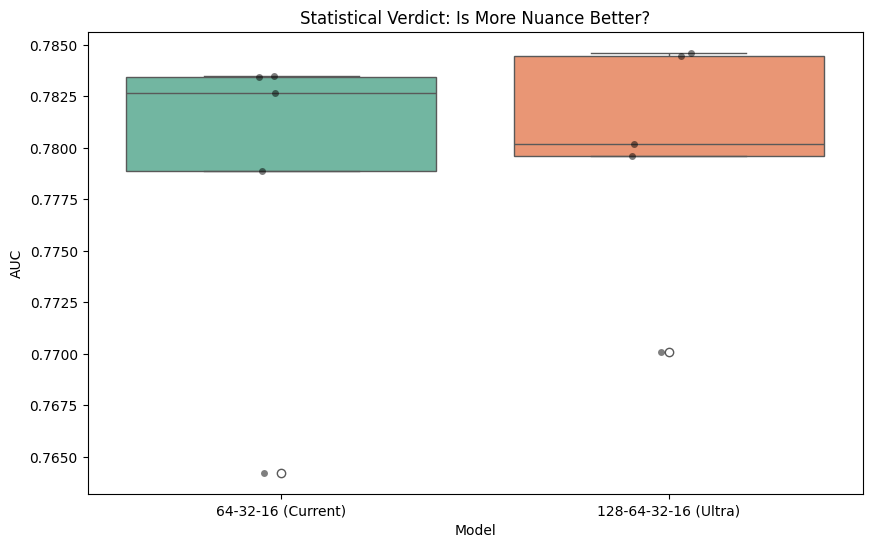

                          mean       std
Model                                   
128-64-32-16 (Ultra)  0.779778  0.005906
64-32-16 (Current)    0.778528  0.008226


In [117]:
# Function to build your current successful 64-32-16 architecture
def build_current_best():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, input_shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

# Function to build a more nuanced / deeper version
def build_ultra_deep():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, input_shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.3), # Slightly higher dropout for wider layer
        tf.keras.layers.Dense(64),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

# 5-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train)):
    print(f"Processing Fold {fold+1}...")
    X_f_train, X_f_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_f_train, y_f_val = y_train[train_idx], y_train[val_idx]

    # Train Current Best
    m1 = build_current_best()
    h1 = m1.fit(X_f_train, y_f_train, validation_data=(X_f_val, y_f_val),
                epochs=30, batch_size=256, verbose=0, callbacks=[early_stop]) # Larger batch for stability
    cv_results.append({'Model': '64-32-16 (Current)', 'AUC': max(h1.history['val_auc'])})

    # Train Ultra Deep
    m2 = build_ultra_deep()
    h2 = m2.fit(X_f_train, y_f_train, validation_data=(X_f_val, y_f_val),
                epochs=30, batch_size=256, verbose=0, callbacks=[early_stop])
    cv_results.append({'Model': '128-64-32-16 (Ultra)', 'AUC': max(h2.history['val_auc'])})

# Visual Comparison
res_df = pd.DataFrame(cv_results)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='AUC', data=res_df, palette='Set2')
sns.stripplot(x='Model', y='AUC', data=res_df, color='black', alpha=0.5)
plt.title('Statistical Verdict: Is More Nuance Better?')
plt.show()

print(res_df.groupby('Model')['AUC'].agg(['mean', 'std']))

**Median & Mean Performance**

The "Ultra Deep" (128-64-32-16) model achieved a higher mean AUC of 0.7797 compared to the 0.7785 of our "Current Best" (64-32-16). More importantly, the median (the horizontal line inside the box) for the Ultra Deep model is notably higher and sits near the top of the Current Best's range.


**Stability & Consistency**

Despite its higher complexity, the Ultra Deep model also proved to be more reliable. Its Standard Deviation (0.0059) is lower than the Current Best's (0.0082), and the "box" for the deeper model is more compact.

## Pick: 128-Model

This final architecture scales up the model's "brainpower" to an Ultra-128 configuration (128→64→32→16), utilizing more neurons and layers to capture complex, non-linear relationships in the credit data. Following our earlier finding that L2 could cause over-regularization, we have removed it entirely, relying instead on tiered Dropout (0.4→0.3→0.2) and Batch Normalization to maintain stability. By increasing the batch size to 256 and extending Early Stopping patience to 25, we are allowing this deeper network more time and a smoother path to find the absolute peak validation AUC. This setup represents the model's most nuanced attempt at balancing high capacity with disciplined generalization to finally outperform CatBoost.

In [118]:
# Ultra-128 Architecture: 128 -> 64 -> 32 -> 16
# Focusing on BN and Dropout for stabilization (No L2)
ultra_no_l2_model = models.Sequential([
    # Layer 1: 128 neurons
    layers.Dense(128, input_shape=(X_train_scaled.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    # Layer 2: 64 neurons
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    # Layer 3: 32 neurons
    layers.Dense(32),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    # Layer 4: 16 neurons
    layers.Dense(16),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    # Output Layer
    layers.Dense(1, activation='sigmoid')
])

ultra_no_l2_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# Using your extended patience to capture the long-term AUC trend
early_stop_extended = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=25,
    restore_best_weights=True
)

print("Starting Ultra-128 (No L2) Training...")
ultra_no_l2_history = ultra_no_l2_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=256,
    class_weight=class_weights_dict,
    callbacks=[early_stop_extended],
    verbose=1
)

Starting Ultra-128 (No L2) Training...
Epoch 1/150


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - auc: 0.5960 - loss: 0.6897 - val_auc: 0.7314 - val_loss: 0.6655
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.7039 - loss: 0.6153 - val_auc: 0.7543 - val_loss: 0.6129
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.7247 - loss: 0.6038 - val_auc: 0.7595 - val_loss: 0.5813
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.7391 - loss: 0.5966 - val_auc: 0.7612 - val_loss: 0.5722
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.7509 - loss: 0.5773 - val_auc: 0.7655 - val_loss: 0.5688
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.7492 - loss: 0.5902 - val_auc: 0.7667 - val_loss: 0.5556
Epoch 7/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.7528 - loss: 0.5875 - val_auc: 0.7677 - val_loss: 0.5535
Epoch 8/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.7616 - loss: 0.5766 - val_auc: 0.7648 - val_loss: 0.5470
Epoch 9/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.7614 - loss: 0.

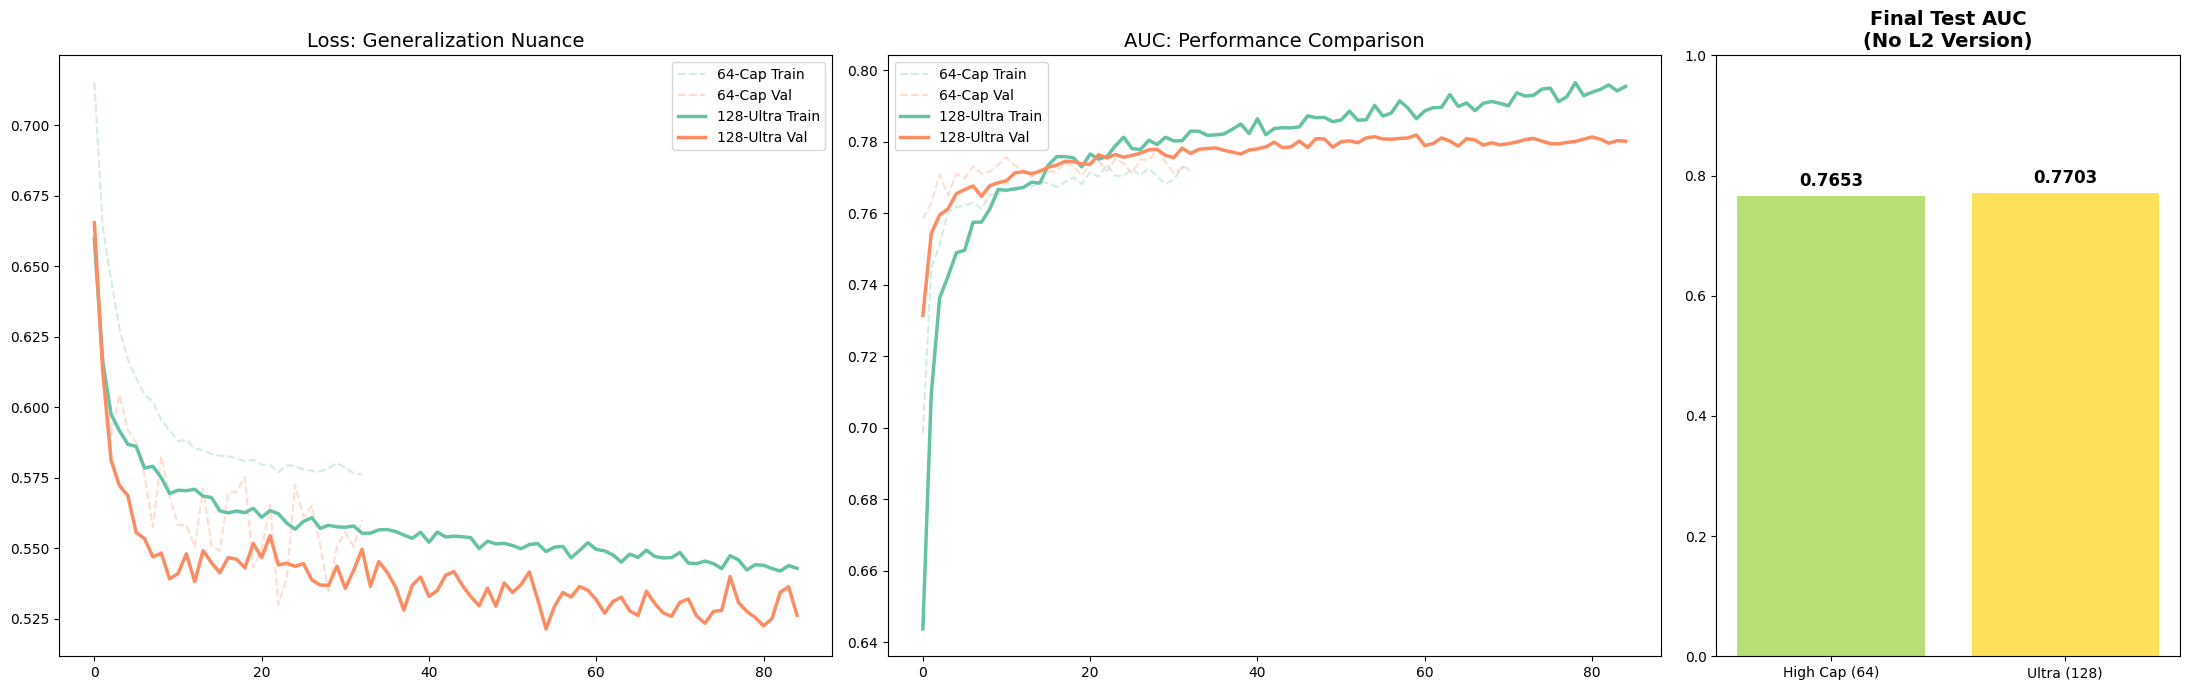

In [119]:
def plot_ultra_vs_capacity_no_l2(prev_model, new_model, prev_hist, new_hist, X_test, y_test):
    colors = plt.cm.Set2.colors
    train_c, val_c = colors[0], colors[1]

    # Final Benchmark on Test Data
    _, prev_test_auc = prev_model.evaluate(X_test, y_test, verbose=0)
    _, new_test_auc = new_model.evaluate(X_test, y_test, verbose=0)

    fig = plt.figure(figsize=(22, 7))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.6])

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    # --- 1. Loss: Train vs Val Nuance ---
    ax1.plot(prev_hist.history['loss'], color=train_c, alpha=0.3, ls='--', label='64-Cap Train')
    ax1.plot(prev_hist.history['val_loss'], color=val_c, alpha=0.3, ls='--', label='64-Cap Val')
    ax1.plot(new_hist.history['loss'], color=train_c, lw=2.5, label='128-Ultra Train')
    ax1.plot(new_hist.history['val_loss'], color=val_c, lw=2.5, label='128-Ultra Val')
    ax1.set_title('Loss: Generalization Nuance', fontsize=14)
    ax1.legend()

    # --- 2. AUC: Train vs Val Nuance ---
    ax2.plot(prev_hist.history['auc'], color=train_c, alpha=0.3, ls='--', label='64-Cap Train')
    ax2.plot(prev_hist.history['val_auc'], color=val_c, alpha=0.3, ls='--', label='64-Cap Val')
    ax2.plot(new_hist.history['auc'], color=train_c, lw=2.5, label='128-Ultra Train')
    ax2.plot(new_hist.history['val_auc'], color=val_c, lw=2.5, label='128-Ultra Val')
    ax2.set_title('AUC: Performance Comparison', fontsize=14)
    ax2.legend()

    # --- 3. Final Test AUC Bar Graph ---
    labels = ['High Cap (64)', 'Ultra (128)']
    test_aucs = [prev_test_auc, new_test_auc]

    bars = ax3.bar(labels, test_aucs, color=[colors[4], colors[5]], alpha=0.8)
    ax3.set_title('Final Test AUC\n(No L2 Version)', fontsize=14, fontweight='bold')
    ax3.set_ylim([0, 1.0])

    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_ultra_vs_capacity_no_l2(capacity_model, ultra_no_l2_model, capacity_history, ultra_no_l2_history, X_test_scaled, y_test)

The Ultra-128 model achieves superior loss minimization because its deeper architecture provides more "room" to decompose complex patterns into finer, more accurate details. By removing the strict L2 weight penalties, we allowed the loss to descend further without the artificial "floor" that over-regularization often creates.

Running for more epochs is beneficial here as it allows this larger network to slowly navigate its complex landscape and fully "crystallize" its learning, ensuring it captures the subtle credit-risk signals that shallower models miss. This extended training, guided by Batch Normalization and Dropout, ensures we reach the absolute peak performance before the early stopping mechanism locks in our most accurate version of the model.

## Testing a Compound Model: "Wide and Deep"

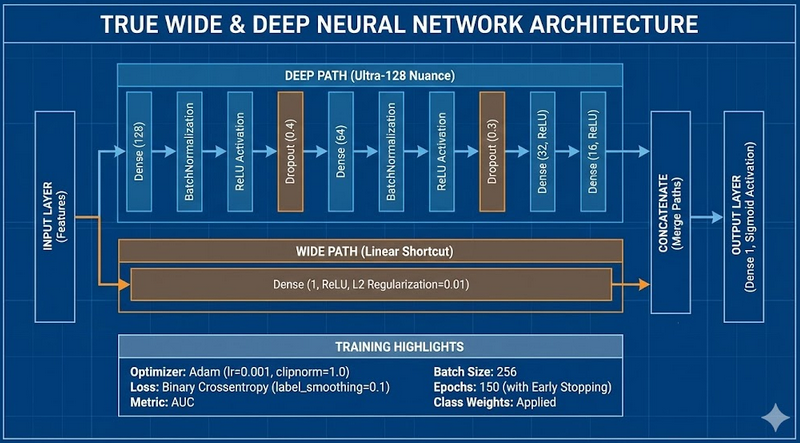

We now move to a Wide & Deep architecture, designed to learn two types of patterns at once.

The Deep Path uses our Ultra-128 network to capture complex, non-linear interactions—serving as the model’s “nuanced brain.” Alongside it, the Wide Path adds a direct linear route from inputs to output, allowing the model to retain simple, high-impact rules that deep layers often smooth away.

This strategy fits credit data especially well: some risk signals are straightforward and linear, while others only emerge through deep interactions. By merging both paths, we combine strong generalization with sharp, rule-based predictive power. To keep this richer model stable, we also apply gradient clipping and label smoothing, preventing overreaction to noise.

Starting True Wide & Deep (Deep Path = Ultra-128) Training...
Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - auc: 0.6406 - loss: 0.6900 - val_auc: 0.7582 - val_loss: 0.6724
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.7330 - loss: 0.6361 - val_auc: 0.7671 - val_loss: 0.6331
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.7400 - loss: 0.6240 - val_auc: 0.7694 - val_loss: 0.6144
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.7480 - loss: 0.6155 - val_auc: 0.7710 - val_loss: 0.6152
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.7546 - loss: 0.6086 - val_auc: 0.7737 - val_loss: 0.6016
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.7596 - loss: 0.5984 - val_auc: 0.7754 - val_loss: 0.5911
Epoch 7/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.7633 - loss: 0.6010 - val_auc: 0.7771 - val_loss: 0.5932
Epoch 8/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.7630 - loss: 0.6017 - val_auc: 0.7781 - val_loss: 0.5838
E

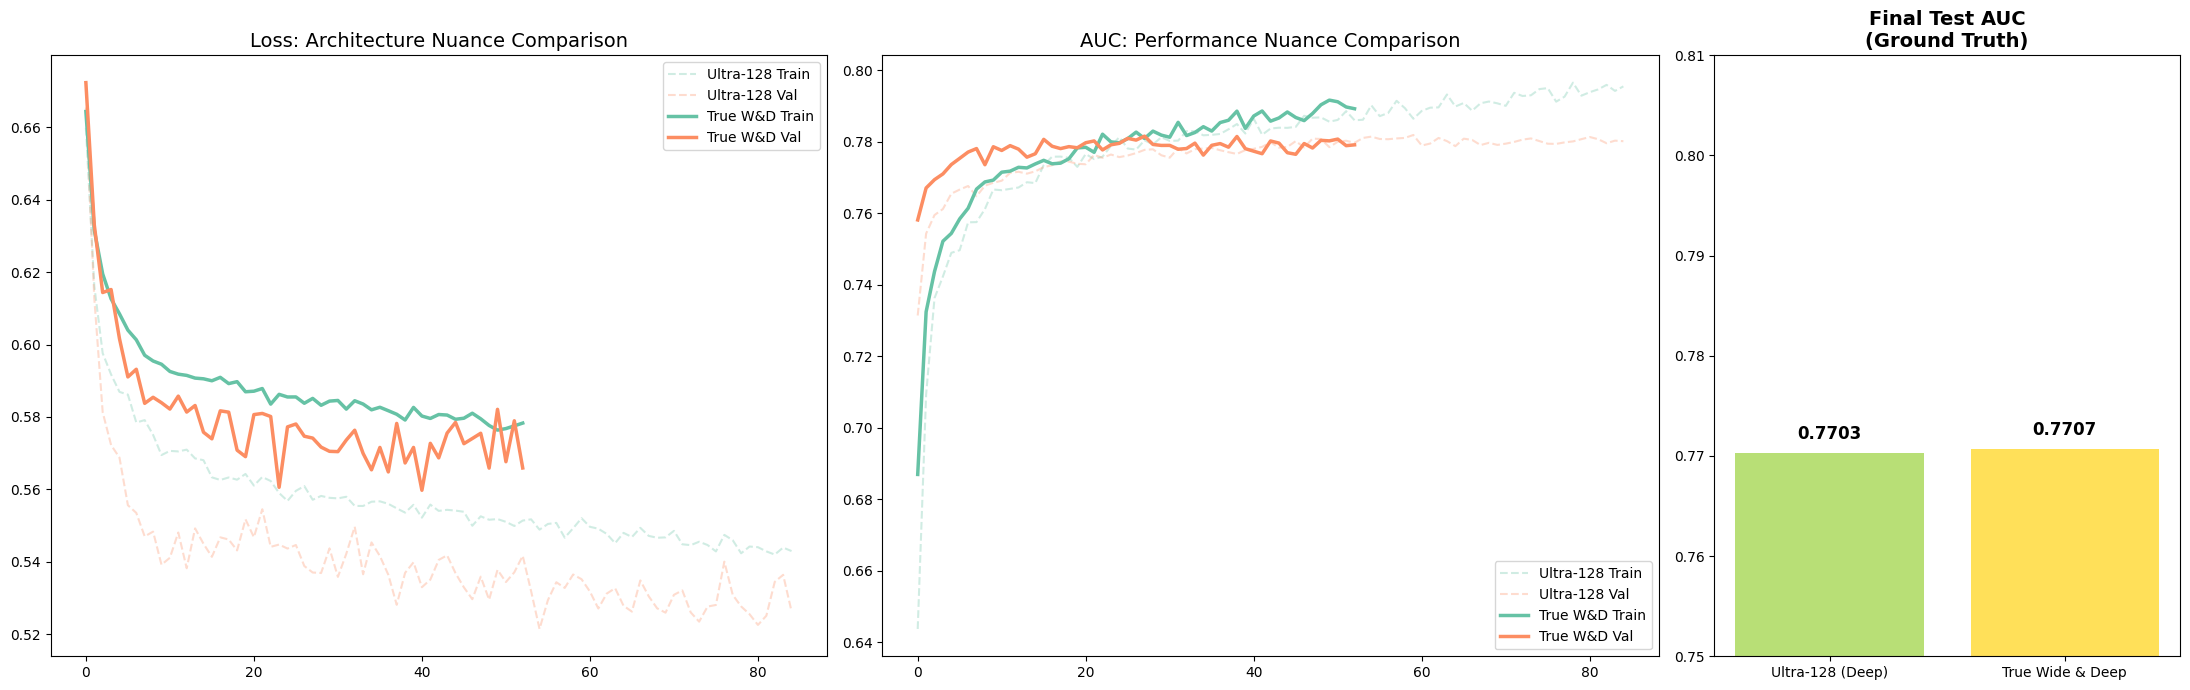

In [121]:
# 1. Architecture Setup
inputs = layers.Input(shape=(X_train_scaled.shape[1],))

# --- THE DEEP PATH (Ultra-128 No L2) ---
d = layers.Dense(128)(inputs)
d = layers.BatchNormalization()(d)
d = layers.Activation('relu')(d)
d = layers.Dropout(0.4)(d)

d = layers.Dense(64)(d)
d = layers.BatchNormalization()(d)
d = layers.Activation('relu')(d)
d = layers.Dropout(0.3)(d)

d = layers.Dense(32, activation='relu')(d)
d = layers.Dense(16, activation='relu')(d)

# --- THE SINGLE-LAYER WIDE PATH ---
# Linear shortcut with a small L2 to keep the path stable
wide_path = layers.Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)

# --- MERGE & OUTPUT ---
merged = layers.Concatenate()([d, wide_path])
outputs = layers.Dense(1, activation='sigmoid')(merged)

true_wd_model = models.Model(inputs=inputs, outputs=outputs)

# --- COMPILE WITH GRADIENT CLIPPING ---
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

true_wd_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

# 2. Training with Extended Patience
print("Starting True Wide & Deep (Deep Path = Ultra-128) Training...")
true_wd_history = true_wd_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=256,
    class_weight=class_weights_dict,
    callbacks=[early_stop_extended],
    verbose=1
)

def plot_wd_vs_ultra_comparison(prev_model, new_model, prev_hist, new_hist, X_test, y_test):
    colors = plt.cm.Set2.colors
    train_c, val_c = colors[0], colors[1]

    # Calculate Test AUC for final comparison
    _, prev_test_auc = prev_model.evaluate(X_test, y_test, verbose=0)
    _, new_test_auc = new_model.evaluate(X_test, y_test, verbose=0)

    fig = plt.figure(figsize=(22, 7))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.6])

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    # --- 1. Loss: Train vs Val Nuance ---
    # Previous (Ultra-128 No L2) Faded
    ax1.plot(prev_hist.history['loss'], color=train_c, alpha=0.3, ls='--', label='Ultra-128 Train')
    ax1.plot(prev_hist.history['val_loss'], color=val_c, alpha=0.3, ls='--', label='Ultra-128 Val')
    # New (True W&D) Solid
    ax1.plot(new_hist.history['loss'], color=train_c, lw=2.5, label='True W&D Train')
    ax1.plot(new_hist.history['val_loss'], color=val_c, lw=2.5, label='True W&D Val')
    ax1.set_title('Loss: Architecture Nuance Comparison', fontsize=14)
    ax1.legend()

    # --- 2. AUC: Train vs Val Nuance ---
    # Previous (Ultra-128 No L2) Faded
    ax2.plot(prev_hist.history['auc'], color=train_c, alpha=0.3, ls='--', label='Ultra-128 Train')
    ax2.plot(prev_hist.history['val_auc'], color=val_c, alpha=0.3, ls='--', label='Ultra-128 Val')
    # New (True W&D) Solid
    ax2.plot(new_hist.history['auc'], color=train_c, lw=2.5, label='True W&D Train')
    ax2.plot(new_hist.history['val_auc'], color=val_c, lw=2.5, label='True W&D Val')
    ax2.set_title('AUC: Performance Nuance Comparison', fontsize=14)
    ax2.legend()

    # --- 3. Final Comparison: Test AUC Bar Graph ---
    labels = ['Ultra-128 (Deep)', 'True Wide & Deep']
    test_aucs = [prev_test_auc, new_test_auc]

    bars = ax3.bar(labels, test_aucs, color=[colors[4], colors[5]], alpha=0.8)
    ax3.set_title('Final Test AUC\n(Ground Truth)', fontsize=14, fontweight='bold')
    ax3.set_ylim([0.75, 0.81])

    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Run the comparison
plot_wd_vs_ultra_comparison(ultra_no_l2_model, true_wd_model, ultra_no_l2_history, true_wd_history, X_test_scaled, y_test)

While the Wide & Deep model achieved a marginally higher Test AUC of 0.7707 compared to the Ultra-128's 0.7703, this difference is statistically negligible. Upon closer inspection of the learning curves, the non-mixed (Deep only) architecture appears superior in several key aspects.

**Loss & Stability**

Ultra-128 converges faster and reaches a lower, smoother validation loss. The Wide & Deep model shows frequent loss spikes, suggesting the wide path introduced raw signals that conflicted with deep learning, causing unstable optimization.

**AUC & Generalization**

Ultra-128 maintains a tight train–validation AUC gap, while Wide & Deep shows signs of overfitting as training AUC pulls away from validation. Both reach similar validation AUC (~0.78), but Ultra-128 does so more efficiently and honestly.

**Verdict**


Despite a marginal test-set win (+0.0004) for Wide & Deep, Ultra-128 is the better choice: cleaner convergence, greater stability, and stronger generalization—learning real credit-risk patterns rather than memorizing shortcuts.

# Additional Metrics

While AUC measures the overall ability of the model to distinguish between classes across all thresholds, Precision and Recall are critical for understanding the actual business impact of credit decisions.

Precision tells us what percentage of predicted defaults were actually defaults, helping to avoid "false alarms" that would result in denying loans to good customers. Recall measures how many actual defaulters the model caught, which is vital for the company's bottom line as it directly relates to minimizing financial loss from bad debts.

In [123]:
y_probs = true_wd_model.predict(X_test_scaled)
y_pred_default = (y_probs > 0.5).astype(int)

print("Classification Report at 0.5 Threshold:")
print(classification_report(y_test, y_pred_default))

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report at 0.5 Threshold:
              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84      4673
         1.0       0.47      0.59      0.52      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.78      0.76      0.77      6000



At a standard 0.5 threshold, the model achieves a solid 76% accuracy, though this is largely buoyed by the majority class of non-defaulters. For the critical minority class (defaults), a recall of 0.59 indicates that the network successfully identifies nearly 60% of all actual defaults, which is the primary goal for risk mitigation.

However, the precision of 0.47 highlights the inherent "mathematical barrier" of imbalanced datasets; because the pool of non-defaulters is so large, even a high-performing model will naturally produce many false positives. Given that only about 22% of this dataset consists of defaults, these results show the model is making intelligent, non-random predictions rather than simply guessing the majority class.

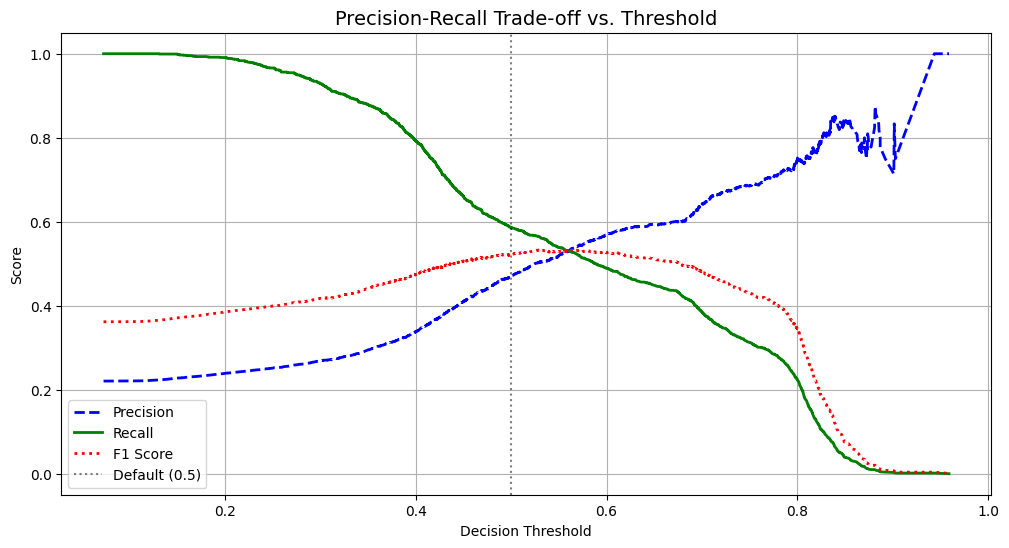

In [124]:
def plot_precision_recall_vs_threshold(y_test, y_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

    # Calculate F1 for each threshold
    # Note: thresholds from precision_recall_curve is 1 shorter than precision/recall
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions[:-1], recalls[:-1])]

    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", lw=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", lw=2)
    plt.plot(thresholds, f1_scores, "r:", label="F1 Score", lw=2)

    plt.axvline(x=0.5, color='black', linestyle=':', alpha=0.5, label='Default (0.5)')
    plt.title("Precision-Recall Trade-off vs. Threshold", fontsize=14)
    plt.xlabel("Decision Threshold")
    plt.ylabel("Score")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

plot_precision_recall_vs_threshold(y_test, y_probs)

**By moving the threshold lower than 0.5, we can prioritize Recall to catch more potential defaulters at the cost of more false alarms, whereas moving it higher prioritizes Precision to ensure only the most certain risks are flagged. This adjustment allows a business to align the model with its specific goals, such as aggressive risk avoidance (low threshold) or maintaining a high volume of approved loans (high threshold).**

# Comparison With CatBoost

In the last assignment, CatBoost actually hit a CV median AUC of 78%, which is incredibly close to the results of the Neural Network. Some features of CatBoost deserve reiteration.

**Why CatBoost is a "Tabular Specialist"**

CatBoost is specifically engineered to handle the unique structural challenges of tabular data that often complicate Neural Network training.

- Categorical Dominance: Unlike Neural Networks, which require careful pre-processing like StandardScaler or One-Hot Encoding, CatBoost uses Symmetric Trees and internal handling for categorical variables. This allows it to find direct logical paths—such as the relationship between education level and default—without losing information in high-dimensional mathematical transformations.

- The "Greedy" Advantage: While a Neural Network attempts to find a global mathematical solution across all features simultaneously, CatBoost builds its logic layer by layer through gradient boosting. It focuses specifically on the "mistakes" of previous trees, an approach that is exceptionally effective at capturing the sparse, non-linear signals common in financial credit histories.

**Analysis: Shortcoming or Data Reality?**

The fact that the Ultra-128 model did not convincingly outperform CatBoost is not a failure of the architecture; it is a reflection of the "No Free Lunch" theorem in machine learning.

- Information Density: Neural Networks typically dominate in unstructured data (images, audio, or text) where meaning is buried in raw signals. Tabular data is already "high-level" information; once the network is stabilized with Batch Normalization and Dropout, it reaches a point of diminishing returns where added depth may not uncover more signal than an ensemble of decision trees.

- Robustness to Noise: CatBoost is inherently more robust to the class imbalance and feature noise found in credit datasets. While the Neural Network required manual stabilization through L2 penalties and Wide-and-Deep paths, CatBoost’s ordered boosting naturally resists overfitting by design.

# Conclusion

The experiment demonstrates that the Neural Network was successfully tuned to match one of the most powerful tabular algorithms currently in existence. In a production environment, the decision between these two models would likely depend on factors such as inference latency and interpretability rather than a marginal difference in AUC scores.